In [147]:
import numpy as np
import json
import requests 
rnd = np.random
rnd.seed(0)

In [148]:
response = requests.get('http://127.0.0.1:5000/geocode')

In [149]:
n = len(response.json()['longitude'])
Q = 500
N = [i for i in range(1, n)]
V = [0] + N
q = {i: rnd.randint(1, 10) for i in N}

In [150]:
#input
# loc_y= np.array([11.026829830511458, 11.000032289646322, 11.009194665389133, 10.89167346812154, 11.026996214865315])
# loc_x= np.array([76.93035690329974, 76.95381913315647, 76.95947192353994, 76.99085176956464, 76.94524171004645])

loc_y= np.array(json.loads(response.text)['latitude'])
loc_x= np.array(json.loads(response.text)['longitude'])
print(loc_y, len(loc_x))

[11.024202 11.026739] 2


(76.9267265, 77.0064215, 11.024075150000002, 11.026865849999998)

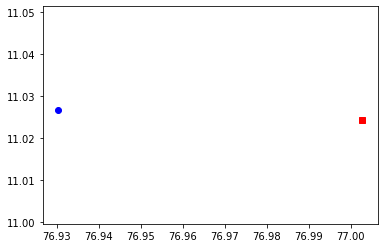

In [151]:
import matplotlib.pyplot as plt
plt.scatter(loc_x[1:], loc_y[1:], c='b')
# for i in N:
#     plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

In [152]:
from docplex.mp.model import Model
mdl = Model('CVRP')

In [153]:
A = [(i, j) for i in V for j in V if i != j]
A

[(0, 1), (1, 0)]

In [154]:
c = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}
c

{(0, 1): 0.07249440577726281, (1, 0): 0.07249440577726281}

In [155]:
x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')

In [156]:
mdl.minimize(mdl.sum(c[i, j]*x[i, j] for i, j in A))
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.add_constraints(u[i] >= q[i] for i in N)
mdl.parameters.timelimit = 15
solution = mdl.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               15
Found incumbent of value 0.144989 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 3 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.02 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.00 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.00 ticks)


In [157]:
print(solution)

solution for: CVRP
objective: 0.144989
x_0_1=1
x_1_0=1
u_1=500.000



In [158]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

(76.9267265, 77.0064215, 11.024075150000002, 11.026865849999998)

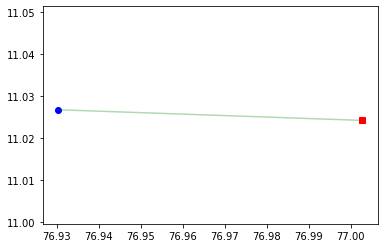

In [159]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs[:-1]:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

In [160]:
#plot the solution in a map using folium
import folium
from folium import plugins

# create map

m = folium.Map(location=[loc_y.mean(), loc_x.mean()], zoom_start=10)

# add home 
folium.Marker([loc_y[0], loc_x[0]], popup='Home', icon=folium.Icon(color='red', icon='home')).add_to(m)
# add markers
for i in N:
        folium.Marker([loc_y[i], loc_x[i]], popup=(loc_y[i], loc_x[i])).add_to(m)

# add lines
for i, j in active_arcs[:-1]:

    folium.PolyLine(locations=[[loc_y[i], loc_x[i]], [loc_y[j], loc_x[j]]], color='red', weight=2.5, opacity=1).add_to(m)

# display map
m


In [161]:
print(active_arcs)
sorted_coords = [active_arcs[0]]

while len(sorted_coords)!=len(active_arcs):
    for i in active_arcs:
        if i in sorted_coords:
            continue
        last = len(sorted_coords)-1
        print(sorted_coords)
        if sorted_coords[last][1] == i[0]:
            sorted_coords.append(i)

[(0, 1), (1, 0)]
[(0, 1)]


In [162]:
stops_arranged = ""
for i, j in sorted_coords:
    stops_arranged+=loc_y[i].astype(str)+","+loc_x[i].astype(str)+"|"
    print(stops_arranged)

11.024202,77.002799|
11.024202,77.002799|11.026739,76.930349|


In [163]:
import requests

url = "https://trueway-directions2.p.rapidapi.com/FindDrivingRoute"

querystring = {"stops":stops_arranged}

headers = {
    "X-RapidAPI-Key": "954bd9e800mshf505c10f126c98dp193b7cjsnf78c048d56c5",
    "X-RapidAPI-Host": "trueway-directions2.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{
  "route": {
    "distance": 9739,
    "duration": 1579,
    "bounds": {
      "south": 11.016692,
      "west": 76.930336,
      "north": 11.026755,
      "east": 77.005169
    },
    "geometry": {
      "coordinates": [
        [
          11.024145,
          77.00278
        ],
        [
          11.024145,
          77.00279
        ],
        [
          11.024155,
          77.00279
        ],
        [
          11.024155,
          77.002801
        ],
        [
          11.024155,
          77.002811
        ],
        [
          11.024145,
          77.002811
        ],
        [
          11.024145,
          77.002821
        ],
        [
          11.024145,
          77.002831
        ],
        [
          11.024145,
          77.002841
        ],
        [
          11.024135,
          77.002851
        ],
        [
          11.024135,
          77.002861
        ],
        [
          11.024125,
          77.002861
        ],
        [
          11.024125,
    

In [164]:
import json
data = json.loads(response.text)
coords=(data['route']['geometry']['coordinates'])

for j,k in coords:
    print(j,k)


11.024145 77.00278
11.024145 77.00279
11.024155 77.00279
11.024155 77.002801
11.024155 77.002811
11.024145 77.002811
11.024145 77.002821
11.024145 77.002831
11.024145 77.002841
11.024135 77.002851
11.024135 77.002861
11.024125 77.002861
11.024125 77.002871
11.024115 77.002882
11.024104 77.002892
11.024094 77.002892
11.024084 77.002902
11.024074 77.002902
11.024064 77.002902
11.024064 77.002912
11.024054 77.002912
11.024044 77.002912
11.024033 77.002912
11.024023 77.002912
11.024013 77.002902
11.024003 77.002902
11.023993 77.002902
11.023993 77.002892
11.023983 77.002892
11.023973 77.002882
11.023962 77.002871
11.023952 77.002871
11.023952 77.002861
11.023952 77.002851
11.023942 77.002851
11.023942 77.002841
11.023942 77.002831
11.023932 77.002821
11.023932 77.002811
11.023881 77.002831
11.023739 77.002871
11.02377 77.002983
11.023841 77.003389
11.023851 77.00343
11.023891 77.003806
11.023902 77.003868
11.023973 77.004244
11.023983 77.004295
11.024003 77.004428
11.024044 77.004611
11.02

In [165]:
import folium
import pandas as pd


def create_map(response):
   # use the response
   mls = response
   points = [(i,k) for i,k in mls]
   m = folium.Map(location=[loc_y.mean(), loc_x.mean()], zoom_start=10)
   # add marker
   folium.Marker([loc_y[0], loc_x[0]], popup='Home', icon=folium.Icon(color='red', icon='home')).add_to(m)
   for i in N:
        folium.Marker([loc_y[i], loc_x[i]], popup='q_%d=%d' % (i, q[i])).add_to(m)
   folium.PolyLine(points, weight=5, opacity=1).add_to(m)
   return m
m = create_map(coords)
m